In this file, we detect the switching pts without rank deduction. 

For CPD, we sum the Amat for each subject and

do not do orthogonalization B1 (U) but make B2 (V) orthornormal, but sparsify the B1 and lambda at each rank using simplex projection

In [1]:
import scipy
import mat73
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from functools import partial
from pprint import pprint

from collections import defaultdict as ddict
from easydict import EasyDict as edict


%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT, FIG_ROOT

In [3]:
# gtvdn
import gtvdn.gtvdn_det_CPD
importlib.reload(gtvdn.gtvdn_det_CPD)
from gtvdn.gtvdn_det_CPD import screening_4CPD, dyna_prog_4CPD

import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_eigvals, update_kp

import gtvdn.gtvdn_pre
importlib.reload(gtvdn.gtvdn_pre)
from gtvdn.gtvdn_pre import preprocess_MEG

import gtvdn.gtvdn_utils
importlib.reload(gtvdn.gtvdn_utils)
from gtvdn.gtvdn_utils import get_bspline_est , get_newdata, get_Amats, get_Nlogk

In [4]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl, load_pkl, save_pkl_dict2folder, load_pkl_folder2dict

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.tensor
importlib.reload(utils.tensor)
from utils.tensor import decompose_three_way_orth, decompose_three_way_fix, sort_orthCPD

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

## Some fns

In [5]:
# truncate small value in vec
def _cumsum_trunc(vec, cutoff=0.9):
    vec = vec.copy()
    idxs = cumsum_cutoff(vec, cutoff)
    counter_idxs = np.delete(np.arange(len(vec)), idxs)
    vec[counter_idxs] = 0
    return vec

In [6]:
# plot the corrmat with 7 canonical nets
def _corr_plot(vecs, cutoff=0.05, trun_fn=lambda x:x, trans_fn=np.abs):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    assert vecs.shape[0] == 68
    corrMat = np.zeros((7, vecs.shape[-1]))
    for ix in range(vecs.shape[-1]):
        curU = vecs[:, ix]
        curU = trun_fn(curU)
        for iy, kz in enumerate(_paras.canon_net_names):
            curV = _paras.canon_nets[kz]
            curV = trun_fn(curV)
            corr_v, pv = scipy.stats.pearsonr(curU, curV)
            if pv <= cutoff:
                corrMat[iy, ix] = corr_v
            else:
                corrMat[iy, ix] = 0
            
    plt.figure(figsize=[15, 5])
    trans_corrMat = trans_fn(corrMat)
    sns.heatmap(trans_corrMat,  yticklabels=_paras.canon_net_names, 
                cmap="coolwarm", center=0, 
                vmin=-1, vmax=1, annot=np.round(trans_corrMat, 2))
    return corrMat

## Set parameters

In [7]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012012

In [8]:
# in case you want to update any parameters
paras.keys()

dict_keys(['is_detrend', 'decimate_rate', 'T', 'lamb', 'fct', 'downsample_rate', 'r', 'Lmin', 'maxM', 'kappa', 'wh', 'kps', 'L', 'num_ranks', 'cutoff', 'Cs', 'penalty', 'data_dir', 'res_dir', 'fig_dir', 'cur_dir'])

In [9]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method3"
_paras.save_dir = RES_ROOT/_paras.folder_name
print(f"Save to {_paras.save_dir}")

Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3


In [10]:
# load results
cur_res = load_pkl_folder2dict(RES_ROOT/_paras.folder_name)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/cpts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/ndXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/My

## Load data

In [10]:
datFil = list(DATA_ROOT.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]

In [11]:
datFil = list(DATA_ROOT.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]

In [12]:
ADdatAdd = loadmat(DATA_ROOT/"DK_timecourse.mat")["DK_timecourse"]

In [13]:
CtrldatAdd = mat73.loadmat(DATA_ROOT/"timecourse_ucsfCONT_group.mat")["dk10"]

In [14]:
baseDF = pd.read_csv(DATA_ROOT/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)

In [15]:
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

In [18]:
defNetsFil = list(DATA_ROOT.glob("DK_dic68.csv"))[0]

defNets = pd.read_csv(defNetsFil).T

DefNets_dict = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    DefNets_dict[curCol[0]] = np.array(curCol[1:])
net_names = sorted(DefNets_dict.keys())

_paras.canon_nets = DefNets_dict
_paras.canon_net_names = net_names

## Run 

### Bspline smooth

In [28]:
Ymat_ctrl = preprocess_MEG(CtrlDatsAll[:], paras)
Ymat_AD = preprocess_MEG(ADDatsAll[:], paras)

NameError: name 'CtrlDatsAll' is not defined

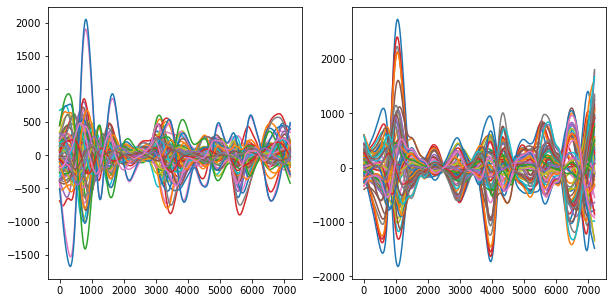

In [12]:
time_span = np.linspace(0, paras.T, Ymat_AD.shape[-1])

if not ("dXXmats_AD" in cur_res.keys()):
    dXmats_AD, Xmats_AD = get_bspline_est(Ymat_AD, time_span, paras.lamb)
    dXmats_ctrl, Xmats_ctrl = get_bspline_est(Ymat_ctrl, time_span, paras.lamb)
    cur_res.dXXmats_AD = [dXmats_AD, Xmats_AD]
    cur_res.dXXmats_ctrl = [dXmats_ctrl, Xmats_ctrl]
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

dXmats_AD, Xmats_AD = cur_res.dXXmats_AD
dXmats_ctrl, Xmats_ctrl = cur_res.dXXmats_ctrl

plt.figure(figsize=[10, 5])
plt.subplot(121)
for ix in range(68):
    plt.plot(Xmats_AD[0, ix, :])
plt.subplot(122)
for ix in range(68):
    plt.plot(Xmats_ctrl[0, ix, :])

### Estimate Amats

In [13]:
if not ("Amats_AD" in cur_res.keys()):
    Amats_ADs_lowrank = get_Amats(dXmats_AD[:], Xmats_AD[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=False)
    cur_res.Amats_AD = Amats_ADs_lowrank
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
Amats_ADs_lowrank = cur_res.Amats_AD

In [14]:
if not ("Amats_ctrl" in cur_res.keys()):
    Amats_ctrls_lowrank = get_Amats(dXmats_ctrl[:], Xmats_ctrl[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=False)
    cur_res.Amats_ctrl = Amats_ctrls_lowrank
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
Amats_ctrls_lowrank = cur_res.Amats_ctrl

### rank-R CP decomposition

In [22]:
import tensorly as tl
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
# CPD decomposition for 3-d tensor such that
# U (first-way) is sparse and norm 1
# V (second-way) is orthornomal
def decompose_three_way_myway(tensor, rank, max_iter=501, verbose=False, init=None, eps=1e-3):
    
    def _err_fn(vl, v):
        err = np.linalg.norm(vl-v)/np.linalg.norm(v)
        return err

    if init is None:
        aT, _ = np.linalg.qr(np.random.random((rank, tensor.shape[0])).T)
        a = aT.T
        bT, _ = np.linalg.qr(np.random.random((rank, tensor.shape[1])).T)
        b = bT.T
        #c = np.random.random((rank, tensor.shape[2]))
    else:
        aT, bT = init
        a, b = aT.T, bT.T

    last_est = [0, 0, 0]
    for epoch in range(max_iter):
        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))
        
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))
        
        # make a sparse and
        trans_a = []
        for curU in a:
            curU_proj = euclidean_proj_l1ball(curU, s=np.abs(curU).sum()/3)
            curU_proj_norm = curU_proj/np.linalg.norm(curU_proj)
            trans_a.append(curU_proj_norm)
        a = np.array(trans_a)

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))
        bT, _ = np.linalg.qr(b.T)
        b = bT.T
        #b = orth(b.T).T
        
        # calculate error
        al, bl, cl = last_est
        errs = [_err_fn(al, a), _err_fn(bl, b), _err_fn(cl, c)]
        last_est = [a, b, c]
        
        if np.max(errs) < eps:
            break


        if verbose and epoch % int(max_iter * .01) == 0:
            res_a = np.square(input_a.dot(a) - target_a).mean()
            res_b = np.square(input_b.dot(b) - target_b).mean()
            res_c = np.square(input_c.dot(c) - target_c).mean()
            print(f"Epoch: {epoch}, Loss ({res_a:.3f}, {res_b:.3f}, {res_c:.3f}), Err ({errs[0]:.3e}, {errs[1]:.3e}, {errs[2]:.3e}).")

    return a.T, b.T, c.T


In [23]:
# transform to tensor
tensors_ctrl = np.transpose(np.array(Amats_ctrls_lowrank), (1, 2, 0))
tensors_AD = np.transpose(np.array(Amats_ADs_lowrank), (1, 2, 0))

# the initial value 
Amat_ctrl_lowrank = np.sum(tensors_ctrl, axis=-1)
U, _, VT = np.linalg.svd(Amat_ctrl_lowrank)
ctrl_CPD_init = [U[:, :paras.r], VT.T[:, :paras.r]]

In [15]:
# rank-R decomposition
if not ("CPDresult_ctrl" in cur_res.keys()):
    CPDresult_ctrl = sort_orthCPD(decompose_three_way_myway(tensors_ctrl, paras.r, init=ctrl_CPD_init, verbose=True))
    CPDresult_AD = decompose_three_way_fix(tensors_AD, init=[CPDresult_ctrl[0], CPDresult_ctrl[1]])
    cur_res.CPDresult_ctrl = CPDresult_ctrl
    cur_res.CPDresult_AD = CPDresult_AD
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
    
CPDresult_ctrl = cur_res.CPDresult_ctrl
CPDresult_AD = cur_res.CPDresult_AD

In [44]:
np.linalg.norm(CPDresult_AD[-1], axis=0)

array([66.13115094, 64.15725453, 35.79431851, 43.33081326, 25.70295069,
       55.69002058, 39.94504247, 48.58558357, 26.6560701 , 59.01791653,
       49.16684087, 47.50038617, 31.72058205, 33.64291985, 18.77164253,
       39.97416805, 31.59040156, 37.38144083, 39.42479134, 65.38089907])

#### corrs with 7 networks

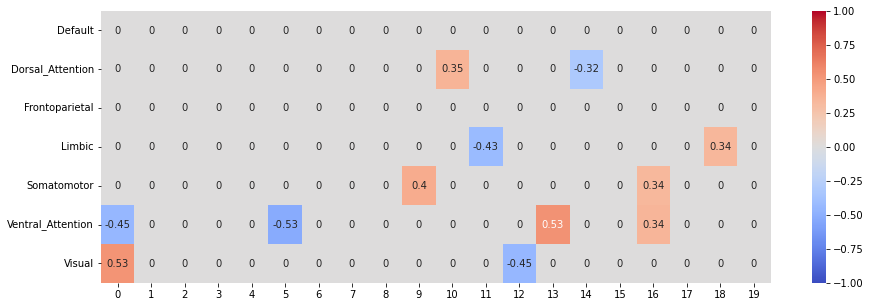

In [19]:
tfn1 = partial(_cumsum_trunc, cutoff=0.90)
_corr_plot(CPDresult_ctrl[0], cutoff=0.01, trun_fn=tfn1, trans_fn=lambda x:x);

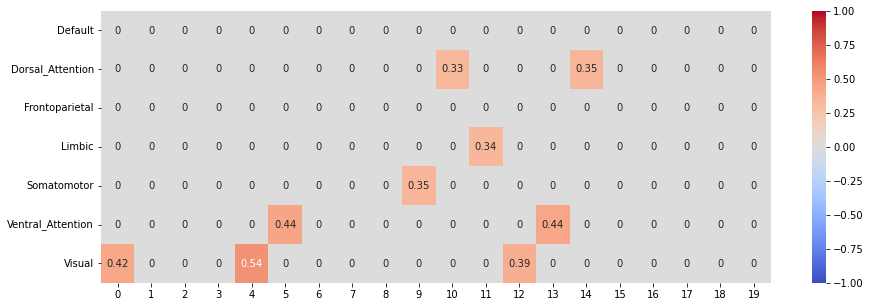

In [20]:
tfn1 = partial(_cumsum_trunc, cutoff=0.90)
_corr_plot(np.abs(CPDresult_ctrl[0]), cutoff=0.01, trun_fn=tfn1, trans_fn=lambda x:x);

### Reduce the dim of the data

In [21]:
B1 = CPDresult_ctrl[0]
B2 = CPDresult_ctrl[1]

In [22]:
# not that B1 is not orthonormal, so you should 
B1tB1 = np.matmul(B1.T, B1)
inv_B1tB1 = np.linalg.inv(B1tB1)

In [23]:
nXmats_ctrl =  np.matmul(B2.T[np.newaxis, :, :], Xmats_ctrl)
nXmats_AD =  np.matmul(B2.T[np.newaxis, :, :], Xmats_AD)


# B1 is not orthornormal
ndXmats_ctrl =  np.matmul(B1.T[np.newaxis, :, :], dXmats_ctrl)
ndXmats_AD =  np.matmul(B1.T[np.newaxis, :, :], dXmats_AD)

ndXmats_ctrl =  np.matmul(inv_B1tB1[np.newaxis, :, :], ndXmats_ctrl)
ndXmats_AD =  np.matmul(inv_B1tB1[np.newaxis, :, :], ndXmats_AD)

In [38]:
if not ("nXmats_ctrl" in cur_res.keys()):
    cur_res.nXmats_ctrl = nXmats_ctrl
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
    
if not ("nXmats_AD" in cur_res.keys()):
    cur_res.nXmats_AD = nXmats_AD
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/.

In [37]:
if not ("ndXmats_ctrl" in cur_res.keys()):
    cur_res.ndXmats_ctrl = ndXmats_ctrl
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
    
if not ("ndXmats_AD" in cur_res.keys()):
    cur_res.ndXmats_AD = ndXmats_AD
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/.

### Screening

In [24]:
if not ("can_pts_ctrls" in cur_res.keys()):
    can_pts_ctrls = screening_4CPD(ndXmats_ctrl, nXmats_ctrl, wh=paras.wh)
    cur_res.can_pts_ctrls = can_pts_ctrls
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
can_pts_ctrls = cur_res.can_pts_ctrls

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [08:47<00:00,  5.99s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/.

In [25]:
if not ("can_pts_ADs" in cur_res.keys()):
    can_pts_ADs = screening_4CPD(ndXmats_AD, nXmats_AD, wh=paras.wh)
    cur_res.can_pts_ADs = can_pts_ADs
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
can_pts_ADs = cur_res.can_pts_ADs

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [09:44<00:00,  6.64s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/.

### Detection

In [35]:
if not ("cpts_ctrls" in cur_res.keys()):
    cpts_ctrls = []
    for ix in trange(len(can_pts_ctrls)):
        res = dyna_prog_4CPD(ndXmats_ctrl[ix], nXmats_ctrl[ix], 
                             paras.kappa, 
                             Lmin=paras.Lmin,  
                             canpts=can_pts_ctrls[ix], 
                             maxM=paras.maxM,  
                             is_full=True,  
                             showProgress=False)
        cpts_ctrls.append(res)
    
    cur_res.cpts_ctrls = cpts_ctrls
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
cpts_ctrls = cur_res.cpts_ctrls

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [19:35<00:00, 13.36s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/.

In [26]:
if not ("cpts_ADs" in cur_res.keys()):
    cpts_ADs = []
    for ix in trange(len(can_pts_ADs)):
        res = dyna_prog_4CPD(ndXmats_AD[ix], 
                             nXmats_AD[ix], 
                             paras.kappa, 
                             Lmin=paras.Lmin,  
                             canpts=can_pts_ADs[ix], 
                             maxM=paras.maxM,  
                             is_full=True,  
                             showProgress=False)
        cpts_ADs.append(res)
    
    cur_res.cpts_ADs = cpts_ADs
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
cpts_ADs = cur_res.cpts_ADs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [26:08<00:00, 17.82s/it]

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/.